Testing the jittable `core.py` functions.

In [1]:
%run init.ipy
from dgf import core
from dgf import isokernels

#config.update("jax_debug_nans", True)

2022-10-26 22:27:10.472953: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


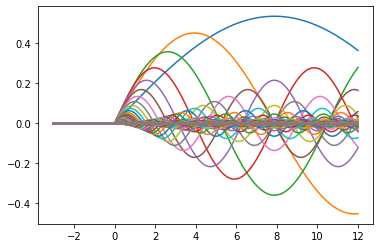

In [29]:
T = 7.
N = 500
M = 128
c = 2.25
L = T*c
t, dt = jnp.linspace(-3., T+5, N, retstep=True)

kernel = isokernels.Matern32Kernel
var = 0.5
r = 1/np.pi
scale = r*T

R = core.kernelmatrix_root_hilbert(kernel, var, scale, t, M, L)
plot(t, core.impose_domain(R, t, 0., L));

In [30]:
%timeit core.kernelmatrix_root_hilbert(kernel, var, scale, t, M, L)

878 µs ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


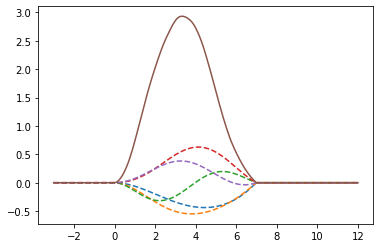

In [50]:
Ru = core.kernelmatrix_root_gfd(kernel, var, scale, t, M, T, c)

plot(t, jnp.cumsum(Ru[:,:5], axis=0)*dt, ls="--");
plot(t, cumsum(Ru @ randn(M))*dt);

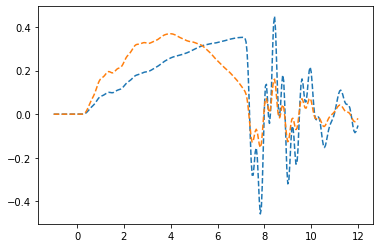

In [5]:
def make_poles(poles_list):
    poles = jnp.array(poles_list)
    poles = -poles.real*jnp.pi + 2*jnp.pi*poles.imag*(1j)
    return poles/1000.

p = make_poles([
    110 + 700j,
    150 + 2500j,
    170 + 2750j,
    150 + 4500j
])

plot(t, core.phi_transfer_matrix(t, M, T, L, p)[:,:2], ls="--");

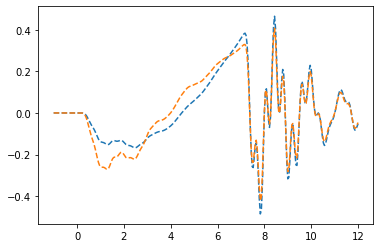

In [6]:
R = core.kernelmatrix_root_convolved_gfd(kernel, var, scale, t, M, T, c, p)
plot(t, R[:,:2], ls="--");

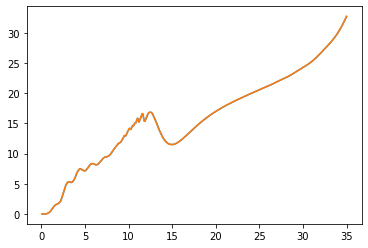

In [7]:
# Test grad T

@jax.jit
def test_grad_T(T):
    R = core.kernelmatrix_root_convolved_gfd(kernel, var, scale, t, M, T, c, p)
    return jnp.sum(R.T @ R) # Just invent a random scalar function

# Grad T can produce nans for excessively smooth spectral densities
# i.e. SqExponentialKernel and CenteredSincKernel. Then we just have
# to decrease the scale parameter, but the `r = length/T` parametrization
# takes care of this automatically.
dtest_grad_T = jax.jit(jax.grad(test_grad_T))

Ts, dT = jnp.linspace(.1, 35, 1000, retstep=True)

f = np.array([test_grad_T(T) for T in Ts])
df = np.array([dtest_grad_T(T) for T in Ts])*dT

plot(Ts, f)
plot(Ts, cumsum(df))

In [8]:
# Test grad with respect to everything

@jax.jit
def testf(x):
    var, scale, a, b, T, c = x
    poles = make_poles([a + b*(1j), 2*a + 2*b*(1j)])
    R = core.kernelmatrix_root_convolved_gfd(kernel, var, scale, t, M, T, c, poles)
    return jnp.sum(R.T @ R)

dtestf = jax.jit(jax.grad(testf))

jax.value_and_grad(testf)(rand(6)*100)

(DeviceArray(1141.32424539, dtype=float64),
 DeviceArray([ 12.50046644, -24.33527035,  -1.10562496,  36.87874486,
                3.1909936 ,  76.06614505], dtype=float64))

In [9]:
w = randn(M)
f = R @ w
%timeit jnp.linalg.lstsq(R, f)

5.41 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


68


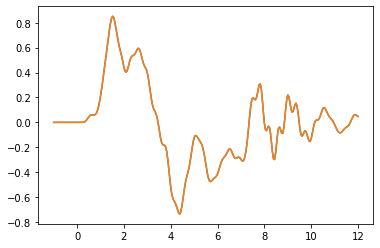

In [10]:
w = randn(M)
f = R @ w
x, res, rank, s = jnp.linalg.lstsq(R, f)
print(rank)
plot(t, f)
plot(t, R @ x)

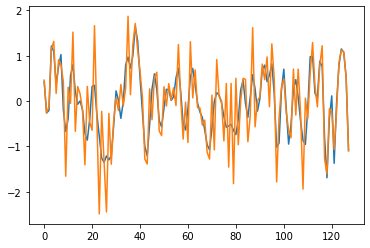

In [11]:
plot(x)
plot(w)

In [12]:
%timeit jnp.linalg.lstsq(R, f)

7.6 ms ± 733 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
jlstsq = jax.jit(jnp.linalg.lstsq)
%timeit jlstsq(R, f)

5.94 ms ± 87.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Check the Hilbert kernel on a grid

In [14]:
N = 300
M = 128

t = np.arange(N) # Grid
y = np.random.rand(N)   # Data lying on the grid
L = N - 1        # Endpoint of the compact domain `[0, L]`

kernel = isokernels.Matern32Kernel
var = 1.3
scale = 2.5
noise_power = .1

# Calculate the log likelihood using the general method
R = core.kernelmatrix_root_hilbert(kernel, var, scale, t, M, L)
L = core.loglikelihood_hilbert(R, y, noise_power)

# Now make use of the fact that the grid spans the compact domain `[0, L]`
L_grid = core.loglikelihood_hilbert_grid(kernel, var, scale, M, y, noise_power)

np.isclose(L, L_grid)

True

In [15]:
%timeit core.loglikelihood_hilbert_grid(kernel, var, scale, M, y, noise_power)

20.1 µs ± 169 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [16]:
%timeit core.loglikelihood_hilbert(R, y, noise_power)

1.68 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
